<a href="https://colab.research.google.com/github/OscarRojasG/Experimentos-GPTValidator/blob/main/Framework_Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework para experimentos GPTValidator

La estructura de carpetas y archivos es la siguiente:

* Datasets
* Miniprompts
  * Ejemplos
  * Contexto
  * Pregunta
  * Respuesta
  * Criteria
  * Reflection
  * Feedback
  * Score
  * Output
* Results

La idea es que los resultados de los experimentos sean guardados en archivos después de cada ejecución.

Para cada experimento se guardarán los siguientes datos:
* Nombre del dataset
* Fecha de ejecución
* Datos por iteración:
  * Puntajes asignados
  * Métricas obtenidas (MSE, RMSE, R^2)
* Resumen de métricas (Media, Desviación estándar)

# Framework para experimentos

In [ ]:
!pip install openai==0.28 &> /dev/null
!pip install openai-multi-client &> /dev/null
!git clone https://github.com/rilianx/GPTEvaluator &> /dev/null

!curl -LO https://raw.githubusercontent.com/OscarRojasG/Experimentos-GPTValidator/main/Experiments.zip &> /dev/null
!unzip -n Experiments.zip &> /dev/null

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

gpt_dicts = [
    {
        'relevance': 10,
        'clarity': 8,
        'precision': 7
    },
    {
        'relevance': 3,
        'clarity': 6,
        'precision': 4
    }
]

real_scores = [3, 2]
criteria = ['relevance', 'clarity', 'precision']

# Función para cálculo de puntajes
def f(x, theta):
    score = np.dot(x, theta[:-3])
    y_pred = np.where(score > theta[-3], 3, np.where(score > theta[-2], 2, np.where(score > theta[-1], 1, 0)))
    return y_pred

# Definir la función de error MSE con penalización por restricciones
def mse_with_penalty(theta, x, y):
    y_pred = f(x, theta)
    mse = np.mean((y - y_pred) ** 2)

    # Penalización por violación de restricciones
    penalty = 1e6 * np.abs(np.sum(theta[:-3]) - 1)  # Penalización grande si la suma de ponderaciones no es 1

    return mse + penalty

# Calcular puntajes finales a partir de puntajes GPT, optimizando ponderaciones y cortes
def get_gpt_scores(gpt_dicts, real_scores, criteria):
    w_bounds = [(0, 1) for _ in range(len(criteria))]

    c_bounds = [(7, 10), (4, 7), (1, 4)]
    bounds = w_bounds + c_bounds

    x = [
        [gpt_dict[key] for key in criteria]
        for gpt_dict in gpt_dicts
    ]
    result = differential_evolution(mse_with_penalty, bounds, args=(x, real_scores), seed=1, strategy='rand1exp')

    gpt_scores = f(x, result.x).tolist()
    params = result.x.tolist()
    params = [round(p, 2) for p in params]
    weights = dict(zip(criteria, params[:-3]))
    cuts = params[-3:]

    return gpt_scores, weights, cuts

get_gpt_scores(gpt_dicts, real_scores, criteria)

([3, 2],
 {'relevance': 0.04, 'clarity': 0.88, 'precision': 0.09},
 [7.69, 4.21, 2.87])

In [ ]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score
from GPTEvaluator.GPTEvaluator import chat_gpt_multiple
from openai_multi_client import OpenAIMultiClient
from datetime import datetime, timedelta
from google.colab import userdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openai
import getpass
import json
import copy
import re
import os

openai.api_key = userdata.get('api_key')

# Genera un prompt a partir de los miniprompts especificados en el diccionario data
def generate_prompt(data):
  def read_file(folder, filename):
    path = f"Experiments/Miniprompts/{folder}/{filename}"
    try:
      return open(path, 'r', encoding='utf-8').read()
    except:
      raise Exception(f"Error: El archivo {path} no existe")

  prompt = ""
  n = len(data.items())

  for i, (key, value) in enumerate(data.items()):
    if key == "instructions":
      prompt += "Instructions: \n"
      for j, (key2, value2) in enumerate(data[key].items()):
        miniprompt = read_file(key2, value2)
        prompt += miniprompt + "\n\n"
    else:
      miniprompt = read_file(key, value)
      prompt += miniprompt

      if i < n-1:
        prompt += "\n\n"

  return prompt

# Carga un dataset a partir de un archivo xlsx y valida sus columnas
def load_dataset(filename, column_data):
  path = f"Experiments/Datasets/{filename}"
  df = pd.read_excel(path)

  mandatory_cols = ["context", "question", "answer", "real_eval"]
  for key in mandatory_cols:
    if key not in column_data.keys():
      raise Exception(f"Error: Debe especificar la columna para la variable {key}")

    value = column_data[key]
    if value not in df.columns:
      raise Exception(f"Error: La columna {value} no existe")

    df = df.rename(columns={value: key})

  return df

# Genera las respuestas con ChatGPT
def eval_gpt(df, prompt):
  api = OpenAIMultiClient(endpoint="chats", data_template={"model": "gpt-3.5-turbo", "temperature": 0.2, "n": 1, "timeout":10}, concurrency=50, wait_interval=1, max_retries=3, retry_max=10, retry_multiplier=1)

  texts = []
  for i, row in df.iterrows():
    text = prompt.format(Question=row['question'], Answer=row['answer'], Context=row['context'])
    texts.append(text)

  answers_gpt = chat_gpt_multiple(api, texts)
  return answers_gpt

# Convierte la respuesta de GPT en un diccionario
def get_gpt_dicts(answers_gpt):
    pattern = r'\{[^{}]+\}'

    gpt_dicts = []
    for answer_gpt in answers_gpt:
        try:
            answer = re.findall(pattern, answer_gpt[0])[0]
            gpt_dicts.append(eval(answer))
        except Exception as e:
            print(f"Error al extraer diccionario. Respuesta GPT: \n{answer_gpt[0]}\n\n")
            gpt_dicts.append(None)

    return gpt_dicts

# Obtiene los puntajes reales de un dataset
def get_real_scores(df):
    return df['real_eval'].tolist()

# Calcula las métricas de evaluación
def get_stats(real_scores, gpt_scores):
  stats = {
      "confusion_matrix": confusion_matrix(real_scores, gpt_scores, labels=[0,1,2,3]).tolist(),
      "mse": mean_squared_error(real_scores, gpt_scores),
      "mae": mean_absolute_error(real_scores, gpt_scores),
      "r2": r2_score(real_scores, gpt_scores),
      "accuracy": accuracy_score(real_scores, gpt_scores),
      "sample_size": len(real_scores)
  }
  return stats

def save_results(dataset, prompt, results, dataset_size, filepath):
  with open(filepath, 'w', encoding='utf-8') as file:
    data = {
        "dataset_name": dataset,
        "dataset_size": dataset_size,
        "prompt": prompt,
        "results": results
    }
    json.dump(data, file, ensure_ascii=False)

def remove_invalid_samples(gpt_dicts, real_scores):
    for i in reversed(range(len(gpt_dicts))):
        if gpt_dicts[i] == None:
            gpt_dicts.pop(i)
            real_scores.pop(i)

# Evalúa un prompt y retorna las estadísticas obtenidas
def evaluate_prompt(df, prompt, criteria):
    try:
        answers_gpt = eval_gpt(df, prompt)
        real_scores = get_real_scores(df)
        gpt_dicts = get_gpt_dicts(answers_gpt)
        remove_invalid_samples(gpt_dicts, real_scores)
        gpt_scores, weights, cuts = get_gpt_scores(gpt_dicts, real_scores, criteria)
        stats = get_stats(real_scores, gpt_scores)

        return {
            'params': {
                'weights': weights,
                'cuts': cuts
            },
            'stats': stats
        }
    except Exception as e:
        print(e)

# Evalúa un prompt para N repeticiones
def evaluate_prompt_n(dataset, column_data, prompt_data, criteria, repetitions, filepath):
    df = load_dataset(dataset, column_data)
    prompt = generate_prompt(prompt_data)
    dataset_size = len(df)
    result_list = []

    for _ in range(repetitions):
        result = evaluate_prompt(df, prompt, criteria)
        result_list.append(result)

    save_results(dataset, prompt, result_list, dataset_size, filepath)

# Retorna una lista con la metadata necesaria para generar cada prompt
def get_prompt_data_list(prompt_data):
  folder_key = None
  instruction = False
  update_count = 0

  for key, value in prompt_data.items():
    if key == "instructions":
      for key2, value2 in prompt_data[key].items():
        if value2 == "*":
          folder_key = key2
          instruction = True
          update_count += 1

    elif value == "*":
      folder_key = key
      update_count += 1

  if update_count == 0: # Sin carpetas, evaluar archivos directamente
    return [prompt_data]
  elif update_count > 1:
     raise Exception(f"Error: Solo una carpeta a la vez como máximo")

  # Recorrer archivos en la carpeta y generar lista de metadatos
  prompt_data_list = []
  path = f"Experiments/Miniprompts/{folder_key}"
  for file in os.listdir(path):
    if os.path.isfile(os.path.join(path, file)):
      prompt_data_copy = copy.deepcopy(prompt_data)
      if instruction: prompt_data_copy["instructions"][folder_key] = file
      else: prompt_data_copy[folder_key] = file
      prompt_data_list.append(prompt_data_copy)

  return prompt_data_list

# Muestra un histograma a partir de la frecuencia de puntajes
def show_histogram(real_counts, pred_counts):
  bins = np.arange(-0.5, 4, 1)
  bin_centers = 0.5 * (bins[:-1] + bins[1:])
  width = 0.35
  plt.bar(bin_centers - width/2, real_counts, width=width, label='Real Eval', align='center')
  plt.bar(bin_centers + width/2, pred_counts, width=width, label='GPT Eval', align='center')

  plt.xlabel('Valor')
  plt.ylabel('Frecuencia')
  plt.title('Histograma')
  plt.legend()
  plt.show()

# Muestra resultados del experimento
def show_results(dir):
  maes = []
  mses = []
  r2s = []
  accuracies = []
  matrices = []
  i = 0

  for filename in os.listdir(dir):
    path = os.path.join(dir, filename)
    if os.path.isfile(path):
      file = open(path, 'r', encoding='utf-8')
      data = json.load(file)

      maes.append([])
      mses.append([])
      r2s.append([])
      accuracies.append([])
      matrices.append([])

      for result in data['results']:
        stats = result['stats']
        maes[i].append(stats['mae'])
        mses[i].append(stats['mse'])
        r2s[i].append(stats['r2'])
        accuracies[i].append(stats['accuracy'])
        matrices[i].append(stats['confusion_matrix'])

      i += 1
      file.close()

  print(f"{'':<15} {'Métrica':<15} {'Media':<15} Desviación estándar\n")
  for i in range(len(maes)):
    print(f"{f'Prompt {i+1}':<15} {'MAE':<15} {round(np.mean(maes[i]),3):<15} {round(np.std(maes[i]),3):<15}")
    print(f"{'':<15} {'MSE':<15} {round(np.mean(mses[i]),3):<15} {round(np.std(mses[i]),3):<15}")
    print(f"{'':<15} {'R2':<15} {round(np.mean(r2s[i]),3):<15} {round(np.std(r2s[i]),3):<15}")
    print(f"{'':<15} {'Accuracy':<15} {round(np.mean(accuracies[i]),3):<15} {round(np.std(accuracies[i]),3):<15}\n")

    matrices_np = np.array(matrices[i])
    matrix_sum = np.sum(matrices_np, axis=0)
    formatted_matrix_sum = str(matrix_sum).split('\n')
    print(f"{'':<15} {'Matriz confusión'}")
    for row in formatted_matrix_sum:
      print(f"{'':<15} {row}")
    print()

    real_counts = [sum(row) for row in matrix_sum]
    pred_counts = [sum(col) for col in list(zip(*matrix_sum))]
    show_histogram(real_counts, pred_counts)
    print()


# Evalúa varios prompts a la vez con N repeticiones
def experiment(dataset, column_data, prompt_data, criteria, repetitions):
    def create_dir():
        date = datetime.now() - timedelta(hours=4)
        formatted_date = date.strftime('%Y%m%d-%H%M')

        dir = f"Experiments/Results/{formatted_date}"
        if not os.path.exists(dir):
            os.makedirs(dir)
        return dir

    try:
        prompt_data_list = get_prompt_data_list(prompt_data)
        dir = create_dir()

        for i, p_data in enumerate(prompt_data_list):
            filepath = f"{dir}/{i+1}.json"
            evaluate_prompt_n(dataset, column_data, p_data, criteria, repetitions, filepath)

        print('\n')
        show_results(dir)
    except Exception as e:
        print(e)


0-37-15-39-40-20-38-4-16-42-26-22-47-3-35-29-8-46-49-18-33-14-17-34-23-19-10-45-13-31-41-32-30-7-5-12-36-44-1-27-43-2-28-21-9-48-6-24-25-11-50-62-56-59-51-65-54-85-53-68-73-57-58-55-83-67-63-91-89-61-76-80-71-72-52-64-77-60-81-92-93-70-84-86-87-90-66-82-94-75-74-97-96-78-88-95-98-69-79-99-100-108-107-105-112-110-113-106-109-103-111-104-101-102-

                Métrica         Media           Desviación estándar

Prompt 1        MAE             0.711           0.0            
                MSE             0.921           0.0            
                R2              0.206           0.0            
                Accuracy        0.386           0.0            

                Matriz confusión
                [[ 7 35  4  1]
                 [ 2 23  1  0]
                 [ 1 13  6  6]
                 [ 0  4  3  8]]



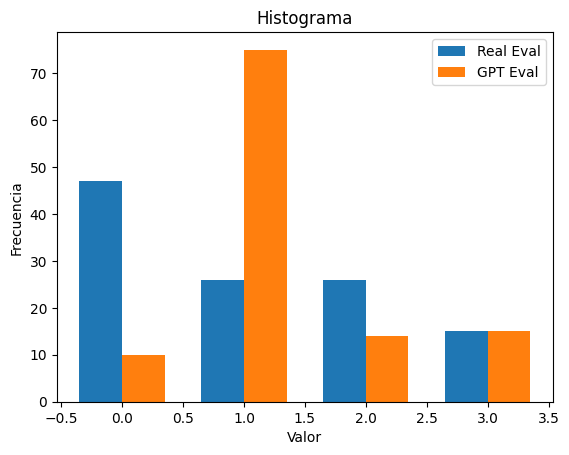

In [ ]:
prompt_data = {
    "examples": "examples_1.txt",
    "context": "context_1.txt",
    "question": "question_1.txt",
    "answer": "answer_1.txt",
    "instructions": {
        "reflection": "reflection_1.txt",
        "feedback": "feedback_1.txt",
        "score": "score_1.txt",
    },
    "criteria": "criteria_1.txt",
    "output": "output_1.txt"
}

column_data = {
    "context": "Contexto",
    "question": "Pregunta",
    "answer": "Respuesta",
    "real_eval": "EvalProfe"
}

criteria = ["correctness", "completeness", "clarity"]

experiment("control2_2024-1.xlsx", column_data, prompt_data, criteria, repetitions=1)